# Analysing differences in incident classification performance using a CNN-KNN model with various pre-trained CNNs

This notebook accompanies a project report written for the Data Science course at the University of Twente.

- Project: CIRI
- Quartile: 2022-1B
- Authors:
  - Stijn Berendse (s.e.berendse@student.utwente.nl)
  - Gilian Schrijver (g.schrijver@student.utwente.nl)
- Project group number: 111

## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import math

from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

## Parameters

_Any parameters applicable to this notebook shall be set here._

In [2]:
NUMBER_OF_FOLDS = 5
SHOW_FIGURE_TITLES = False

## Generic setup

Set the device. Using CUDA on CUDA-enabled devices speeds up the use of convolutional networks significantly.

In [3]:
cuda_enabled = torch.cuda.is_available()

if cuda_enabled:
    device = torch.device("cuda:0")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

We will be using a random number generator every now and then throughout this notebook. By initializing it here, we can change a single seed to obtain the same/different results.

In [4]:
rng = np.random.default_rng(0)

## Load datasets

The images were pre-processed in a different notebook, which means they must now be loaded into this one. To do so, we first define a class that helps in loading the data from the file system. This class was taken from https://medium.com/codex/saving-and-loading-transformed-image-tensors-in-pytorch-f37b4daa9658.

In [5]:
class PreparedData(torch.utils.data.Dataset):
    def __init__(self, img, mask):
        self.img = img  #img path
        self.mask = mask  #mask path
        self.len = len(os.listdir(self.img))

    def __getitem__(self, index):
        ls_img = sorted(os.listdir(self.img))
        ls_mask = sorted(os.listdir(self.mask))

        img_file_path = os.path.join(self.img, ls_img[index])
        img_tensor = torch.load(img_file_path)

        mask_file_path = os.path.join(self.mask, ls_mask[index])
        mask_tensor = torch.load(mask_file_path)

        return img_tensor, mask_tensor

    def __len__(self):
        return self.len

The class defined above is used to create Torch `Dataset`-like objects for the data that was saved to the file system by the other notebook. It constitutes data representing folds for K-Fold cross validation.

In [6]:
data = {}

for i in tqdm(range(NUMBER_OF_FOLDS)):
    data[i] = PreparedData(
        f"./content/fold{i}_loader/img",
        f"./content/fold{i}_loader/target"
    )

with open("./content/data_classes.bin", "rb") as file:
    data_classes = pickle.load(file)

100%|██████████| 5/5 [00:00<00:00, 398.68it/s]


In order to avoid repeating ourselves, a custom `Dataset` class is created that encapsulates multiple Torch `Dataset` objects, as well as dataloaders, targets, class names, etc. This will reduce unnecessary computations and reduce the number of variables that needs to be passed between functions.

In [7]:
class Dataset:
    """
    Represents a dataset from which data, targets and dataloaders can be easily
    extracted. Used mostly as a Data Transfer Object (DTO) to reduce the need
    to pass high numbers of parameters to other functions.
    """

    def __init__(self, datasets, classes):
        """
        Keyword arguments:
        datasets -- dictionary of dataset labels mapped to corresponding Datasets
                    Examples of labels can be "test", "train", "fold1", etc.
        classes  -- a list of all classes that exist in the Datasets
        """
        self.data = datasets
        self.all_classes = classes

        self.targets = {}
        for label, data in self.data.items():
            self.targets[label] = self._get_targets(data)

        self.dataloaders = {}
        for label, data in tqdm(self.data.items()):
            self.dataloaders[label] = DataLoader(
                data,
                batch_size=4,
                shuffle=False
            )

    def _get_targets(self, dataset):
        """Returns the list of targets for a specific dataset."""
        return [target for (_, target) in dataset]

We now use the class defined above to create a DTO for the `PreparedData` objects previously created for each fold.

In [8]:
dataset = Dataset(data, data_classes)

100%|██████████| 5/5 [00:00<00:00, 19065.02it/s]


## Initialize models

We will be comparing multiple models from torchvision, repeating largely equivalent steps for each model. To facilitate the reuse of code and to avoid repeating ourselves, we create a generic `Model` (abstract) class that will be implemented for each torchvision model. Subsequent code can rely on a single, generic interface provided by the `Model` class and need not worry about implementation details.

In [9]:
class Model():
    """
    Represents a generic convolutional model that is used for transfer
    learning, from which descriptors can be extracted for classification.
    """

    def __init__(self, model, name):
        self.model = model
        self.name = name

        for param in self.model.parameters():
            # As the model will not be trained, gradients are not required.
            # Disabling them speeds up performance.
            param.requires_grad = False

        self.model.eval()
        self.remove_classifier()

    def remove_classifier(self):
        """
        Removes the last fully connected layer (the classifier) from the
        model, allowing the extraction of descriptors.
        """
        raise NotImplementedError()

    def to(self, device):
        """Moves the model to the specified device."""
        self.model = self.model.to(device)

    def descriptors(self, dataloader, as_numpy=True):
        """
        Returns the output of the model for all items in the dataloader.
        """
        outputs = []
        with torch.no_grad():
            for data, targets in tqdm(dataloader):
                data = data.to(device)
                output = self.model(data).detach()
                outputs.extend(output)

        if as_numpy:
            outputs = np.array([output.cpu().numpy() for output in outputs])

        return outputs

Later on, we might want to loop over a list of models and perform a function for each of them. Therefore, we initialise a list to which an instance of each model will be appended.

In [10]:
models = []

### VGG16

In [11]:
class Vgg16Model(Model):
    def __init__(self):
        model = torchvision.models.vgg16(weights="DEFAULT")
        super().__init__(model, "VGG16")

    def remove_classifier(self):
        self.model.classifier = nn.Identity()


vgg16 = Vgg16Model()
vgg16.to(device)

models.append(vgg16)

### Inception V3

In [12]:
class InceptionV3Model(Model):
    def __init__(self):
        model = torchvision.models.inception_v3(weights="DEFAULT")
        super().__init__(model, "InceptionV3")

    def remove_classifier(self):
        self.model.fc = nn.Identity()


inception = InceptionV3Model()
inception.to(device)

models.append(inception)

### ResNet-50

In [13]:
class ResNet50Model(Model):
    def __init__(self):
        model = torchvision.models.resnet50(weights="DEFAULT")
        super().__init__(model, "ResNet-50")

    def remove_classifier(self):
        self.model.fc = nn.Identity()


resnet50 = ResNet50Model()
resnet50.to(device)

models.append(resnet50)

### ResNet-18

In [14]:
class ResNet18Model(Model):
    def __init__(self):
        model = torchvision.models.resnet18(weights="DEFAULT")
        super().__init__(model, "ResNet-18")

    def remove_classifier(self):
        self.model.fc = nn.Identity()


resnet18 = ResNet18Model()
resnet18.to(device)

models.append(resnet18)

## Baseline

### Obtain image descriptors

Extracting image descriptors from pre-trained CNNs is a fairly time-consuming process. Therefore, we prefer doing this as infrequently as possible. The `DescriptorManager` class shall help achieve this goal. It provides functionality for saving extracted descriptors to the file system and loading descriptors from the file system, and provides a `get_descriptors` function that extracts or loads descriptors based on whichever is possible.

In [15]:
class DescriptorManager:
    """
    Handles the loading, saving and extraction of data descriptors.
    """

    def __init__(self, model, base_path="./data/descriptors"):
        self.model = model
        self.base_path = base_path
        self.descriptors = {}

    def _create_path(self, label):
        """
        Creates a standardised path for descriptors with the provided model name
        and label to prevent inconsistencies between loading and saving descriptors.
        """
        return f"{self.base_path}/{self.model.name}/descriptors_{label}.bin"

    def save_descriptors(self, descriptors, label):
        """
        Saves the provided descriptor to the file system at a path derived from
        the model name and label.
        """
        path = self._create_path(label)
        os.makedirs(os.path.dirname(path), exist_ok=True)

        with open(path, "wb") as file:
            pickle.dump(descriptors, file)

    def extract_descriptors(self, dataloader, label):
        """
        Extracts descriptors from the provided model and saves them to this
        DescriptorManager.
        """
        descriptors = self.model.descriptors(dataloader, True)
        self.descriptors[label] = descriptors

        return descriptors

    def load_descriptors(self, label):
        """
        Loads and returns the provided descriptors from the file system, based
        on the provided model name and label.
        """
        path = self._create_path(label)

        with open(path, "rb") as file:
            self.descriptors[label] = pickle.load(file)

            return self.descriptors[label]

    def get_descriptors(self, dataloader, label):
        """
        Returns cached descriptors, returns descriptors from the file system or
        extracts and saves new descriptors from the model, based on which is
        available.

        Keyword arguments:
        dataloader -- DataLoader with data for which descriptors are retrieved
        label -- the label for this data (e.g. "train", "test", "fold1", etc.)
        """
        if label in self.descriptors:
            return self.descriptors[label]

        try:
            return self.load_descriptors(label)
        except FileNotFoundError:
            descriptors = self.extract_descriptors(dataloader, label)
            self.save_descriptors(descriptors, label)

            return descriptors

### Perform K-Nearest Neighbors (KNN) classification

In [16]:
class MetricResult:
    def __init__(self, average, stdev):
        self.average = average
        self.stdev = stdev


class DescriptorAssessmentResult:
    def set_accuracy(self, accuracy, stdev):
        self.accuracy = MetricResult(accuracy, stdev)

    def set_precision(self, average, stdev):
        self.precision = MetricResult(average, stdev)

    def set_f1_score(self, average, stdev):
        self.f1_score = MetricResult(average, stdev)


class DescriptorAssessor:
    def __init__(self, descriptor_manager):
        self.descriptor_manager = descriptor_manager

    def assess(self, dataset, n_neighbors_list):
        """
        Analyses the classification performance of a KNN classifier through K-fold
        cross validation for all numbers of n_neighbors in the provided
        n_neighbors_list.

        Keyword arguments:
        dataset          -- Dataset comprised of multiple folds of data
        n_neighbors_list -- list of for which KNN classifiers should be generated
                            and assessed

        Returns:
        A triple (targets, predictions, results).
        - targets is a dictionary keyed by the cross validation round;
        - predictions and results are dictionaries keyed by the number of
          neighbors for which the results were achieved. For each value of
          n_neighbors, targets and predictions contain a dictionary, keyed by
          the cross validation round.
        """
        cv_combinations = self._get_cv_combinations(dataset)
        cv_targets = self._get_cv_targets(cv_combinations)

        n_cv_predictions = {}
        n_results = {}
        for n_neighbors in n_neighbors_list:
            cv_predictions = self._get_cv_predictions(cv_combinations, n_neighbors)

            result = DescriptorAssessmentResult()
            result.set_accuracy(
                *(self._get_accuracy(cv_targets, cv_predictions))
            )
            result.set_precision(
                *(self._get_precision(cv_targets, cv_predictions))
            )
            result.set_f1_score(
                *(self._get_f1_score(cv_targets, cv_predictions))
            )

            n_cv_predictions[n_neighbors] = cv_predictions
            n_results[n_neighbors] = result

        return (cv_targets, n_cv_predictions, n_results)

    def _get_descriptors(self, dataset, data_type):
        return self.descriptor_manager.get_descriptors(
            dataset.dataloaders[data_type],
            data_type
        )

    def _get_cv_combinations(self, dataset):
        """
        Returns a list of all train set--test set combinations for cross
        validation, as tuples of (train_folds, test_fold). train_folds is a
        list of data types (used as keys in Dataset data); test_fold is one
        such value.

        Keyword arguments:
        dataset -- Dataset object
        """
        all_folds = list(dataset.data.keys())

        cv_combinations = []
        for test_fold in all_folds:
            train_folds = [fold for fold in all_folds if fold != test_fold]
            cv_combinations.append((train_folds, test_fold))

        return cv_combinations

    def _get_cv_predictions(self, cv_combinations, n_neighbors):
        """
        Performs KNN classification for all cross validation rounds using
        a KNN classifier for the provided number of neighbors.
        """
        cv_predictions = {}

        for train_folds, test_fold in cv_combinations:
            train_descriptors = np.concatenate(
                [self._get_descriptors(dataset, train_fold)
                 for train_fold in train_folds]
            )
            train_targets = np.concatenate(
                [dataset.targets[train_fold] for train_fold in train_folds]
            )

            test_descriptors = self._get_descriptors(dataset, test_fold)

            classifier = KNeighborsClassifier(
                n_neighbors=n_neighbors,
                algorithm="brute"
            ).fit(train_descriptors, train_targets)

            cv_predictions[test_fold] = classifier.predict(test_descriptors)

        return cv_predictions

    def _get_cv_targets(self, cv_combinations):
        cv_targets = {}

        for train_folds, test_fold in cv_combinations:
            cv_targets[test_fold] = dataset.targets[test_fold]

        return cv_targets

    def _get_metric(self, cv_targets, cv_predictions, metric_func):
        """
        Returns a weighted average and corresponding weighted standard
        deviation for the provided metric function.

        Keyword arguments:
        cv_targets -- dictionary of cross validation rounds mapped to their
                      respective test targets
        cv_weights -- dictionary of cross validation rounds mapped to their
                      respective test predictions

        Returns:
        (weighted_average, stdev)
        """
        assert cv_predictions.keys() == cv_targets.keys()
        cv_weights = [len(targets) for _, targets in cv_targets.items()]
        cv_metrics = [
            metric_func(cv_targets[key], cv_predictions[key])
            for key in cv_targets
        ]

        average_metric = np.average(cv_metrics, weights=cv_weights)
        stdev = self._get_stdev(average_metric, cv_metrics, cv_weights)

        return (average_metric, stdev)

    def _get_stdev(
        self,
        average_metric,
        cv_metrics,
        cv_weights
    ):
        """
        Returns a weighted standard deviation.

        Keyword arguments:
        cv_metrics -- list of values of the metric for each fold
        cv_weights -- list of weights of each metric value
        """
        return math.sqrt(np.average(
            (np.array(cv_metrics) - average_metric) ** 2,
            weights=cv_weights
        ))

    def _get_accuracy(self, cv_targets, cv_predictions):
        """
        Returns a weighted average accuracy and corresponding weighted standard
        deviation.

        Keyword arguments:
        cv_targets -- dictionary of cross validation rounds mapped to their
                      respective test targets
        cv_weights -- dictionary of cross validation rounds mapped to their
                      respective test predictions

        Returns:
        (weighted_average, stdev)
        """
        return self._get_metric(cv_targets, cv_predictions, accuracy_score)

    def _get_precision(self, cv_targets, cv_predictions):
        """
        Returns a weighted average precision and corresponding weighted standard
        deviation.

        Keyword arguments:
        cv_targets -- dictionary of cross validation rounds mapped to their
                      respective test targets
        cv_weights -- dictionary of cross validation rounds mapped to their
                      respective test predictions

        Returns:
        (weighted_average, stdev)
        """
        return self._get_metric(
            cv_targets,
            cv_predictions,
            lambda targets, predictions: precision_score(
                targets, predictions, average="macro", zero_division=0
            )
        )

    def _get_f1_score(self, cv_targets, cv_predictions):
        """
        Returns a weighted average f1 score and corresponding weighted standard
        deviation.

        Keyword arguments:
        cv_targets -- dictionary of cross validation rounds mapped to their
                      respective test targets
        cv_weights -- dictionary of cross validation rounds mapped to their
                      respective test predictions

        Returns:
        (weighted_average, stdev)
        """
        return self._get_metric(
            cv_targets,
            cv_predictions,
            lambda targets, predictions: f1_score(
                targets, predictions, average="macro"
            )
        )

In [17]:
class Visualiser:
    def __init__(self, base_path="./figures"):
        self.base_path = base_path

    def print_model_metrics(self, model_name, n_results, best_n_neighbors=None):
        print(f"Metrics for {model_name}:")
        for n_neighbors, result in n_results.items():
            print(
                f"n = {n_neighbors : 3}  | "
                f"acc:  {result.accuracy.average:.5f} +-{result.accuracy.stdev:.5f}  | "
                f"prec: {result.precision.average:.5f} +- {result.precision.stdev:.5f}  | "
                f"f1:   {result.f1_score.average:.5f} +- {result.f1_score.stdev:.5f} "
                f"{'<-- best' if n_neighbors == best_n_neighbors else ''}"
            )

    def plot_metrics(self, model_name, n_results):
        accuracies, accuracies_stdevs = self._get_n_metrics(
            n_results,
            lambda result: result.accuracy
        )
        precisions, precisions_stdevs = self._get_n_metrics(
            n_results,
            lambda result: result.precision
        )
        f1_scores, f1_scores_stdevs = self._get_n_metrics(
            n_results,
            lambda result: result.f1_score
        )

        fig, ax = plt.subplots()
        self._plot_metric(ax, accuracies, accuracies_stdevs, "accuracy")
        self._plot_metric(ax, precisions, precisions_stdevs, "precision (macro-average)")
        self._plot_metric(ax, f1_scores, f1_scores_stdevs, "f1-score (macro-average)")

        ax.legend()
        ax.set_xlabel("k (number of neighbours)")
        ax.set_ylabel("score")

        if SHOW_FIGURE_TITLES:
            ax.set_title(f"kNN classification performance using {model_name} descriptors")

        fig.show()
        self._savefig(fig, f"metrics_{model_name}")

    def plot_multimodel_metrics(self, results):
        fig, ax = plt.subplots()

        for model_name, n_results in results.items():
            accuracies, accuracies_stdev = self._get_n_metrics(
                n_results,
                lambda result: result.accuracy
            )
            self._plot_metric(ax, accuracies, accuracies_stdev, model_name)

        ax.legend()
        ax.set_xlabel("k (number of neighbours)")
        ax.set_ylabel("accuracy")

        if SHOW_FIGURE_TITLES:
            ax.set_title("kNN classification accuracies for k neighbours")

        fig.show()

        self._savefig(fig, "accuracies")

    def plot_confusion_matrix(self, model_name, cm):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()

        fig = disp.figure_
        fig.show()
        self._savefig(fig, f"confusion_matrix_{model_name}")

    def _get_n_metrics(self, n_results, get_metric_func):
        averages = {}
        stdevs = {}

        for n_neighbors, result in n_results.items():
            averages[n_neighbors] = get_metric_func(result).average
            stdevs[n_neighbors] = get_metric_func(result).stdev

        return averages, stdevs

    def _plot_metric(self, ax, averages, stdevs=None, label=""):
        ax.errorbar(
            x=list(averages.keys()),
            y=list(averages.values()),
            # yerr=list(stdevs.values()) if stdevs is not None else None,
            label=label,
            marker="o",
            capsize=3.0,
            elinewidth=1.0
        )

    def _savefig(self, fig, fname):
        fig.savefig(os.path.join(self.base_path, fname))

We want to assess the classification performance using different numbers of neighbours, hence define them here.

In [18]:
n_neighbors_list = [1, 2, 5, 10, 15, 20, 30, 40, 50, 75, 100]

Metrics for VGG16:
n =   1  | acc:  0.36064 +-0.02126  | prec: 0.47284 +- 0.04495  | f1:   0.33039 +- 0.02095 <-- best
n =   2  | acc:  0.34998 +-0.01837  | prec: 0.48276 +- 0.04833  | f1:   0.32745 +- 0.01750 
n =   5  | acc:  0.31726 +-0.02943  | prec: 0.51020 +- 0.08144  | f1:   0.29877 +- 0.02278 
n =  10  | acc:  0.27635 +-0.02783  | prec: 0.44300 +- 0.07340  | f1:   0.25582 +- 0.02010 
n =  15  | acc:  0.24277 +-0.02129  | prec: 0.42956 +- 0.04250  | f1:   0.21952 +- 0.01734 
n =  20  | acc:  0.22203 +-0.02079  | prec: 0.41318 +- 0.02985  | f1:   0.19727 +- 0.01748 
n =  30  | acc:  0.19768 +-0.01926  | prec: 0.41835 +- 0.06062  | f1:   0.17333 +- 0.01751 
n =  40  | acc:  0.17941 +-0.01886  | prec: 0.37555 +- 0.02774  | f1:   0.15370 +- 0.01962 
n =  50  | acc:  0.16353 +-0.01458  | prec: 0.36366 +- 0.03379  | f1:   0.13636 +- 0.01665 
n =  75  | acc:  0.13052 +-0.01374  | prec: 0.36095 +- 0.02441  | f1:   0.09353 +- 0.01910 
n =  100  | acc:  0.11168 +-0.01007  | prec: 0.34956 

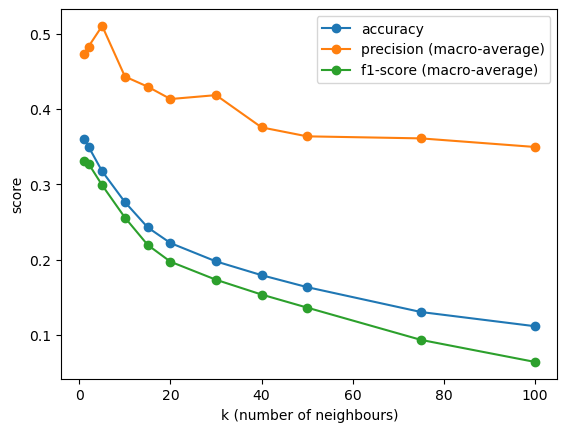

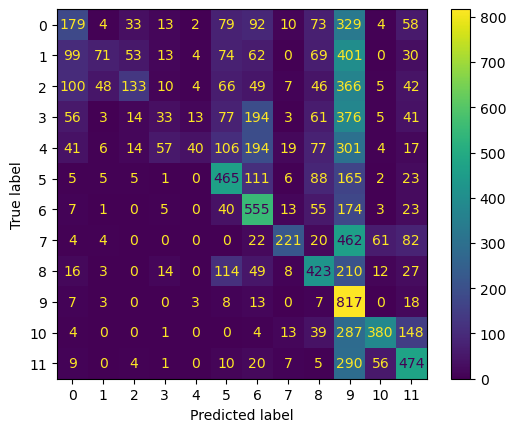

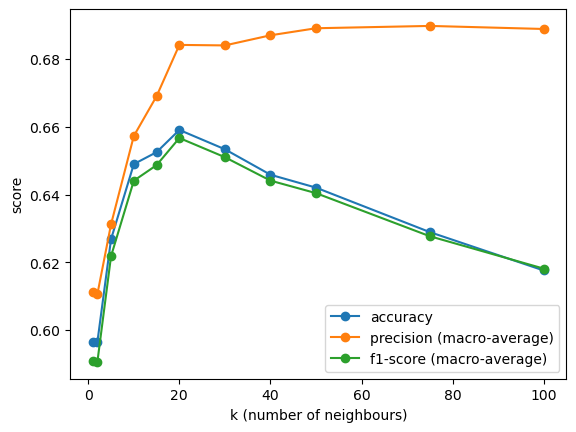

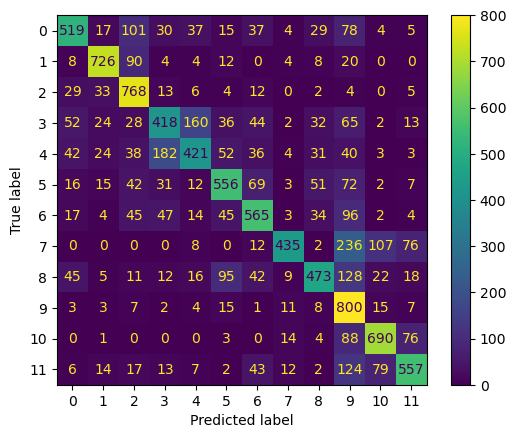

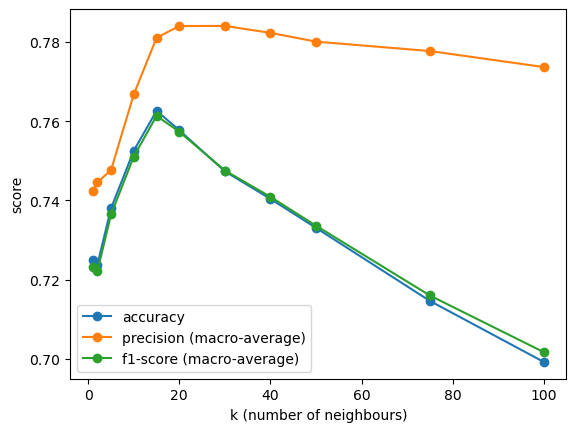

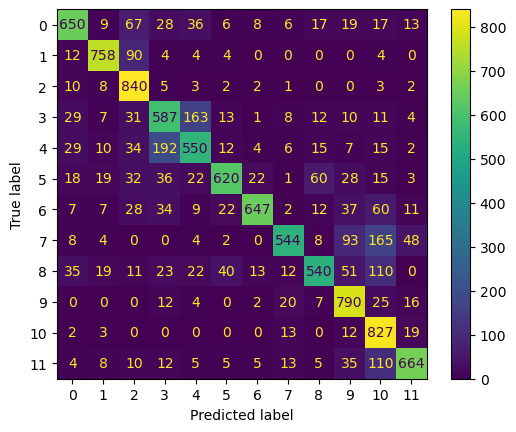

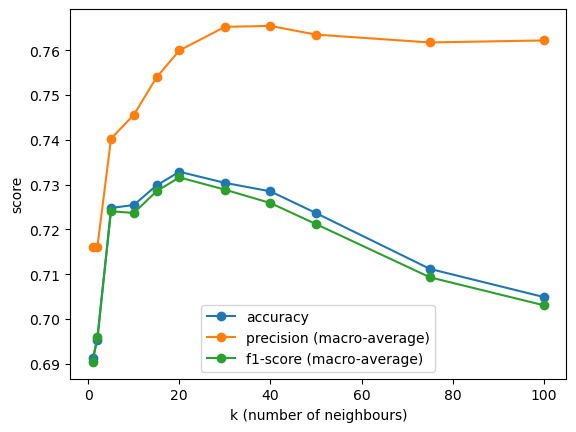

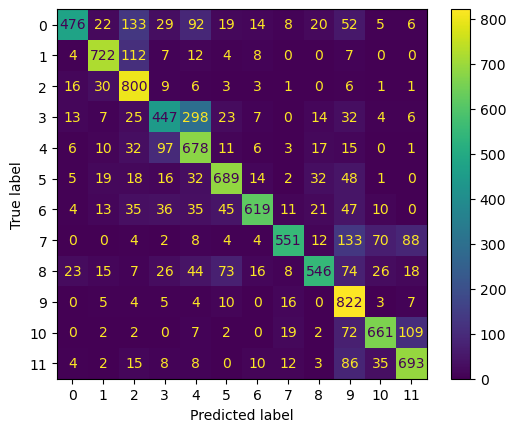

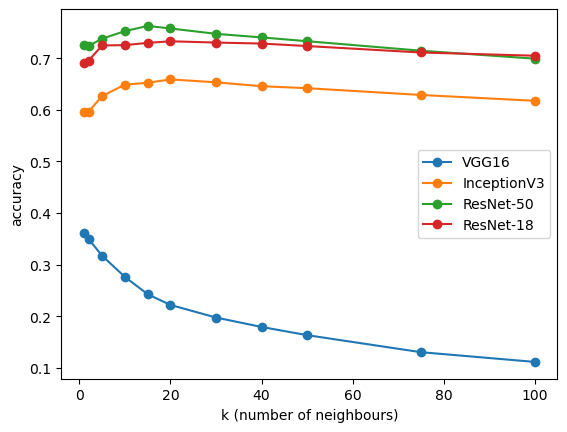

In [19]:
results = {}
visualiser = Visualiser()

for model in models:
    descriptor_manager = DescriptorManager(model)
    descriptor_assessor = DescriptorAssessor(descriptor_manager)

    cv_targets, n_cv_predictions, n_results = descriptor_assessor.assess(
        dataset,
        n_neighbors_list
    )
    results[model.name] = n_results

    best_n_neighbors = max(
        n_results,
        key=lambda n_neighbors: n_results.get(n_neighbors).accuracy.average
    )

    visualiser.print_model_metrics(model.name, n_results, best_n_neighbors)
    visualiser.plot_metrics(model.name, n_results)

    cm = confusion_matrix(
        np.concatenate(list(cv_targets.values())),
        np.concatenate(list(n_cv_predictions[best_n_neighbors].values()))
    )
    visualiser.plot_confusion_matrix(model.name, cm)

visualiser.plot_multimodel_metrics(results)

### Visually assess predicted vs. target through PCA

In [20]:
def plot_predictions_against_targets(fit_pca,
                                     predictions,
                                     targets,
                                     n_classes,
                                     cmap=None):
    """Draws a scatter plot of two-dimensional data which highlights
    differences between targets and predictions through distinct edge and fill
    colors."""

    if cmap is None:
        cmap = plt.get_cmap("rainbow")

    if isinstance(targets, list):
        targets = np.array(targets)

    colors_target = cmap(targets / n_classes)
    colors_predictions = cmap(predictions / n_classes)

    fig, ax = plt.subplots()
    # Plot targets (ground truth) with fill color representing target class
    ax.scatter(fit_pca[:, 0],
               fit_pca[:, 1],
               facecolors=colors_target,
               label="target")

    # Plot predictions with edge color representing predicted class
    ax.scatter(fit_pca[:, 0],
               fit_pca[:, 1],
               facecolors="none",
               edgecolors=colors_predictions,
               label="predicted")

    legend = ax.legend()
    # Set colors to black to indicate the legend is about marker type, rather
    # than color
    legend.legendHandles[0].set_color("black")
    legend.legendHandles[1].set_edgecolor("black")

    return (fig, ax)